In [1]:
import pandas as pd
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
filelocation_TET = 'NDT_all_12thDec_uncleaned.csv'
feelings = ['MetaAwareness','Presence','PhysicalEffort','MentalEffort','Boredom', 'Receptivity', 'EmotionalIntensity', 'Clarity', 'Release', 'Bliss', 'Embodiment', 'Insightfulness', 'Anxiety', 'SpiritualExperience']
header = "Subject"
no_dimensions = 2
colours = {0:'red',1:'green',2:'blue',3:'orange',4:'pink',5:'yellow'}
n_clust = 3
headers = {'Subject':0, 'Week':1, 'Session':2}
lcm = 122,132,780
n_rep = 10

In [ ]:
class traj_kmeans_clustering_trunc:

    def __init__(self,data, feelings, heading, principal_components, n_clust):
        data[["principal componant 1", "principal componant 2"]] = data[feelings].dot(principal_components)
        split_dict = {}
        for (subject, week, session), group in data.groupby(['Subject', 'Week', 'Session']):
            split_dict[(subject, week, session)] = group.copy()
        stacked_array = np.stack([df.iloc[0:43,40:42].values for df in split_dict.values()], axis=2)
        self.data = np.transpose(stacked_array,(1,0,2))
        self.data_all = np.stack([df.iloc[0:43,0:42].values for df in split_dict.values()], axis=2)
        self.heading = heading
        self.n_clust = n_clust
    def data_maker(self):
        return self.data
    def traj_kmeans_mean(self, nrep, avg):
        min_dist = np.inf
        seed_method = '++'
        sum_dist = np.zeros(nrep)
        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=self.data.shape[2])
            clust = np.full((self.data.shape[0], self.data.shape[1], self.n_clust), np.nan)
            dist = np.full((self.data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((self.data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(self.data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(self.data.shape[2])
                    clust[:, :, clust_index] = self.data[:, :, index]

                for _ in range(10000):
                    for i in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(self.data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = self.data[:, :, index]

            aux = np.zeros(self.data.shape[2])
            new_column = np.ones((self.data.shape[1],1, self.data.shape[2]),dtype=int)
            for i in range(0,self.data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  
            sum_dist[n] = np.sum(dist[np.arange(self.data.shape[2]),id_n])
        return id_n, clust, dist, aux, data_all_clust, sum_dist
    def traj_kmeans_mean_diffs(self, nrep, avg):
        data = np.zeros_like(self.data)

        for i in range(self.data.shape[2]):
            for j in range(self.data.shape[0]):
                for k in range(self.data.shape[1] - 1):
                    data[j, k, i] = self.data[j, k + 1, i] - self.data[j, k, i]
        min_dist = np.inf
        seed_method = '++'
        
        sum_dist = np.zeros(nrep)
        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=data.shape[2])
            clust = np.full((data.shape[0], data.shape[1], self.n_clust), np.nan)
            dist = np.full((data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(data.shape[2])
                    clust[:, :, clust_index] = data[:, :, index]

                for _ in range(10000):
                    for i in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = data[:, :, index]

            aux = np.zeros(data.shape[2])
            new_column = np.ones((data.shape[1],1, data.shape[2]),dtype=int)
            for i in range(0,data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  
            sum_dist[n] = np.sum(dist[np.arange(self.data.shape[2]),id_n])
        return id_n, clust, dist, aux, data_all_clust, data, sum_dist
    def traj_plots(self, colours, id_n):
        ax = plt.subplot()


        for i in range(0, self.data.shape[2]):
    
            x_values = []
            y_values = []

    
            for j in range(0, self.data.shape[1]):
                x_values.append(self.data[0][j][i])
                y_values.append(self.data[1][j][i])
            ax.plot(x_values,y_values,label=f"line {i}", color=colours[id_n[i]])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
            ax.plot(self.data[0][0][i],color='black')
            ax.plot(self.data[1][0][i],color='black')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
    def traj_identifier(self, data_all_clust):
        new_column = np.ones((data_all_clust.shape[0],1, data_all_clust.shape[2]),dtype=int)
        for i in range(0,data_all_clust.shape[2]):
            new_column[:,0,i] = i
        data_all_clust_fin = np.column_stack((data_all_clust, new_column)) 
        return data_all_clust_fin   
    def indiv_plots(self, data_all_clust,headers, colours):
        group_by_header = {}

        for i in range(data_all_clust.shape[2]):  # Iterate over the second dimension
            head = tuple(data_all_clust[0][headers[self.heading]][i])
            if head not in group_by_header:
                group_by_header[head] = []
            group_by_header[head].append(data_all_clust[:,:,i])
        names = group_by_header.keys()
        for name in names:
             name_tot = ''.join(name)
             plt.figure()
             plt.title(name_tot)
             for i in range(0,len(group_by_header[name])):
                 x_values = []
                 y_values = []
                 for j in range(0,len(group_by_header[name][i])):
                     x_values.append(group_by_header[name][i][j][-4])
                     y_values.append(group_by_header[name][i][j][-3])
                 
                 plt.plot(x_values,y_values,label=f"line {i}", color=colours[group_by_header[name][i][0][-2]])
                 plt.xlabel('principal componant 1 (bored/effort)')
                 plt.ylabel('principal componant 2 (calm)')
                 plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
                 plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
                 plt.plot(self.data[0][0][i],color='black')
                 plt.plot(self.data[1][0][i],color='black')
                 plt.xlim(-6,6)
                 plt.ylim(-1,2)
        
    def centroid_plotter(self,clust,colours):
        for i in range(0,clust.shape[2]):
            plt.figure()
            plt.title(f'cluster_centroid_{i}')
            x_values = []
            y_values = []
            
            for k in range(0,clust.shape[1]):
                x_values.append(clust[0,k,i])
                y_values.append(clust[1,k,i])
            plt.plot(x_values,y_values,label=f"line {i}", color=colours[i])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")     
            plt.xlim(-6,6)
            plt.ylim(-1,2)
            
    def centroid_plotter_diff(self,clust,colours):
        for i in range(0,clust.shape[2]):
            plt.figure()
            plt.title(f'cluster_centroid_{i}')
            x_values = []
            y_values = []

            for k in range(0,clust.shape[1]):
                x_values.append(sum(clust[0,0:k,i]))
                y_values.append(sum(clust[1,0:k,i]))
        
            plt.plot(x_values,y_values,label=f"line {i}", color=colours[i])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")     
            plt.xlim(-6,6)
            plt.ylim(-1,2)
    def silhouette_et(self, data, id_out, n_clust):
        dist_pairwise = cdist(np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), 
                          np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), metric='euclidean')

        a = np.zeros(data.shape[2])
        b = np.zeros(data.shape[2])
        s = np.zeros(data.shape[2])

        for i in range(data.shape[2]):
            # Calculate the number of points in the same cluster as the current point
            cluster_size = np.sum(id_out == id_out[i])
            
            # If the cluster has only one point, assign a silhouette score of 0
            if cluster_size <= 1:
                s[i] = 0
                continue

            # within-cluster distance
            a[i] = np.nansum(dist_pairwise[i, id_out == id_out[i]]) / (cluster_size - 1)

            # between-cluster distance
            not_clust = np.setdiff1d(np.arange(1, n_clust + 1), id_out[i])

            bmin = np.inf
            for j in not_clust:
                # Calculate the number of points in the current cluster
                cluster_size_j = np.sum(id_out == j)
                
                # If the cluster has no points assigned, skip the calculation
                if cluster_size_j == 0:
                    continue
                    
                b_aux = np.nansum(dist_pairwise[i, id_out == j]) / cluster_size_j
                bmin = min(b_aux, bmin)

            b[i] = bmin

            s[i] = (b[i] - a[i]) / max(a[i], b[i])
        return s

In [ ]:
class traj_kmeans_clustering_interpolate:

    def __init__(self,data, feelings, heading, principal_components, n_clust):
        data[["principal componant 1", "principal componant 2"]] = data[feelings].dot(principal_components)
        split_dict = {}
        for (subject, week, session), group in data.groupby(['Subject', 'Week', 'Session']):
            split_dict[(subject, week, session)] = group.copy()
        stacked_array = np.stack([df.iloc[0:43,40:42].values for df in split_dict.values()], axis=2)
        self.data = np.transpose(stacked_array,(1,0,2))
        self.data_all = np.stack([df.iloc[0:43,0:42].values for df in split_dict.values()], axis=2)
        self.heading = heading
        self.n_clust = n_clust
    def data_maker(self):
        return self.data
    def traj_kmeans_mean(self, nrep, avg):
        min_dist = np.inf
        seed_method = '++'

        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=self.data.shape[2])
            clust = np.full((self.data.shape[0], self.data.shape[1], self.n_clust), np.nan)
            dist = np.full((self.data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((self.data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(self.data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(self.data.shape[2])
                    clust[:, :, clust_index] = self.data[:, :, index]

                for _ in range(1000):
                    for i in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(self.data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = self.data[:, :, index]

            aux = np.zeros(self.data.shape[2])
            new_column = np.ones((self.data.shape[1],1, self.data.shape[2]),dtype=int)
            for i in range(0,self.data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  

        return id_n, clust, dist, aux, data_all_clust
    def traj_kmeans_mean_diffs(self, nrep, avg):
        data = np.zeros_like(self.data)

        for i in range(self.data.shape[2]):
            for j in range(self.data.shape[0]):
                for k in range(self.data.shape[1] - 1):
                    data[j, k, i] = self.data[j, k + 1, i] - self.data[j, k, i]
        min_dist = np.inf
        seed_method = '++'

        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=data.shape[2])
            clust = np.full((data.shape[0], data.shape[1], self.n_clust), np.nan)
            dist = np.full((data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(data.shape[2])
                    clust[:, :, clust_index] = data[:, :, index]

                for _ in range(1000):
                    for i in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = data[:, :, index]

            aux = np.zeros(data.shape[2])
            new_column = np.ones((data.shape[1],1, data.shape[2]),dtype=int)
            for i in range(0,data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  

        return id_n, clust, dist, aux, data_all_clust, data
    def traj_plots(self, colours, id_n):
        ax = plt.subplot()


        for i in range(0, self.data.shape[2]):
    
            x_values = []
            y_values = []

    
            for j in range(0, self.data.shape[1]):
                x_values.append(self.data[0][j][i])
                y_values.append(self.data[1][j][i])
            ax.plot(x_values,y_values,label=f"line {i}", color=colours[id_n[i]])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
            ax.plot(self.data[0][0][i],color='black')
            ax.plot(self.data[1][0][i],color='black')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
    def traj_identifier(self, data_all_clust):
        new_column = np.ones((data_all_clust.shape[0],1, data_all_clust.shape[2]),dtype=int)
        for i in range(0,data_all_clust.shape[2]):
            new_column[:,0,i] = i
        data_all_clust_fin = np.column_stack((data_all_clust, new_column)) 
        return data_all_clust_fin   
    def indiv_plots(self, data_all_clust,headers, colours):
        group_by_header = {}

        for i in range(data_all_clust.shape[2]):  # Iterate over the second dimension
            head = tuple(data_all_clust[0][headers[self.heading]][i])
            if head not in group_by_header:
                group_by_header[head] = []
            group_by_header[head].append(data_all_clust[:,:,i])
        names = group_by_header.keys()
        for name in names:
             name_tot = ''.join(name)
             plt.figure()
             plt.title(name_tot)
             for i in range(0,len(group_by_header[name])):
                 x_values = []
                 y_values = []
                 for j in range(0,len(group_by_header[name][i])):
                     x_values.append(group_by_header[name][i][j][-4])
                     y_values.append(group_by_header[name][i][j][-3])
                 
                 plt.plot(x_values,y_values,label=f"line {i}", color=colours[group_by_header[name][i][0][-2]])
                 plt.xlabel('principal componant 1 (bored/effort)')
                 plt.ylabel('principal componant 2 (calm)')
                 plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
                 plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
                 plt.plot(self.data[0][0][i],color='black')
                 plt.plot(self.data[1][0][i],color='black')
                 plt.xlim(-6,6)
                 plt.ylim(-1,2)

In [ ]:
class csv_splitter:

    def __init__(self,excel_file_name):
        self.excel_file_location = f'c:\\Users\\hugma\\diss\\{excel_file_name}'
        self.dataframes = None
    def read_excel(self):
        try:
            df_excel_file_name = pd.read_csv(self.excel_file_location)
            return df_excel_file_name
        except Exception as e:
            print(f"error reading Excel file: {e}")
    def split_by_header(self,df_excel_file_name, heading):
        if heading not in df_excel_file_name.columns:
            print(f"Error: '{heading}' not found in DataFrame columns.")
            return None
        heading_values = df_excel_file_name[heading].unique()
        split_df = {value: df_excel_file_name[df_excel_file_name[heading] == value] for value in heading_values}
        split_df_array = [[key, value] for key, value in split_df.items()]
        return split_df, split_df_array

In [ ]:
class principal_component_finder:

    def __init__(self,csv_file, feelings,no_dimensions):
        self.csv_file_TET = csv_file[feelings]
        corr_matrix = self.csv_file_TET.corr()
        pca = PCA(n_components=no_dimensions)
        self.principal_components=pca.fit_transform(corr_matrix)
        self.explained_variance_ratio = pca.explained_variance_ratio_
    def PCA_TOT(self):
        df_TET_feelings_prin = self.csv_file_TET.dot(self.principal_components)
        for i in range(0,self.principal_components.shape[1]):
            y_values = []
            for j in range(0,len(feelings)):
                y_values.append(self.principal_components[j][i])
            plt.figure()
            plt.bar(feelings,y_values)
            plt.title(f'principal componant {i+1}')
            plt.xticks(rotation=45, ha='right')
        plt.figure()
        plt.scatter(df_TET_feelings_prin[0],df_TET_feelings_prin[1], s=0.5)
        plt.xlabel('principal componant 1 (bored/effort)')
        plt.ylabel('principal componant 2 (calm)')
        plt.xlim(-6,6)
        plt.ylim(-1,2)
        
        return self.principal_components, self.explained_variance_ratio, df_TET_feelings_prin
    def PCA_split(self,split_df_array):
        split_df_array_TET = [[split_df_array[i][0],split_df_array[i][1][feelings]] for i in range(0,len(split_df_array))]
        split_csv_TET = {split_df_array_TET[i][0]: split_df_array_TET[i][1] for i in range(0,len(split_df_array))}
        df_TET_feelings_prin_dict = {name: split_csv_TET[name].dot(self.principal_components) for name in split_csv_TET.keys()}
        for key,value in df_TET_feelings_prin_dict.items():
            plt.figure()
            plt.scatter(value[0],value[1],s=0.5)
            plt.title(key)
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
            plt.show()
        return df_TET_feelings_prin_dict


In [ ]:
csv_splitter_instance = csv_splitter(filelocation_TET)
df_csv_file = csv_splitter_instance.read_excel()
split_df, split_csv_array = csv_splitter_instance.split_by_header(df_csv_file,header)

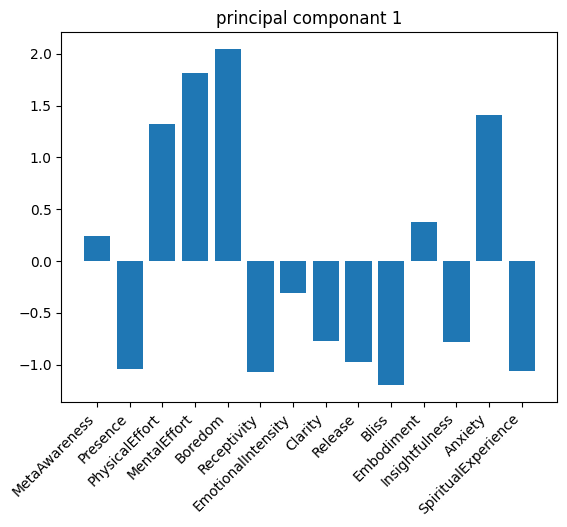

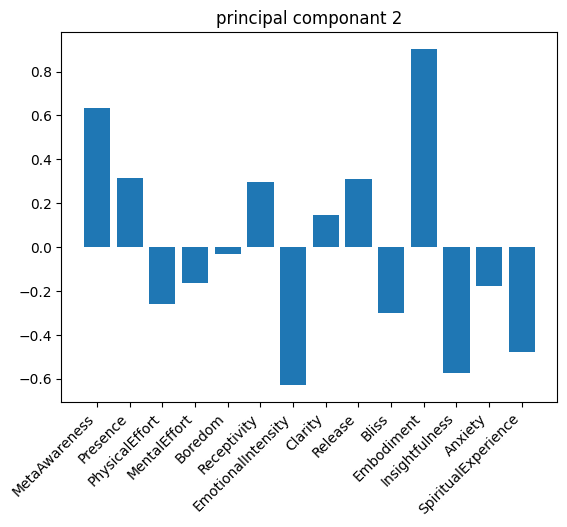

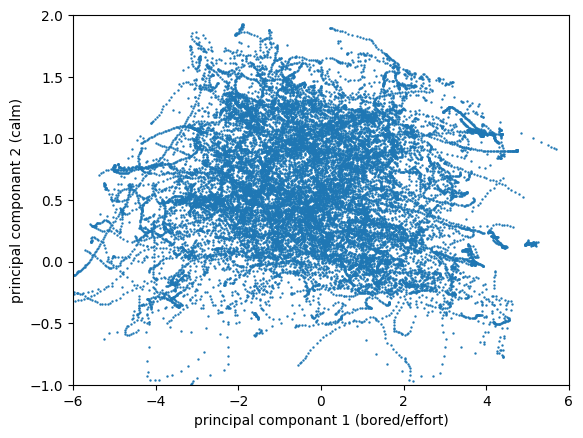

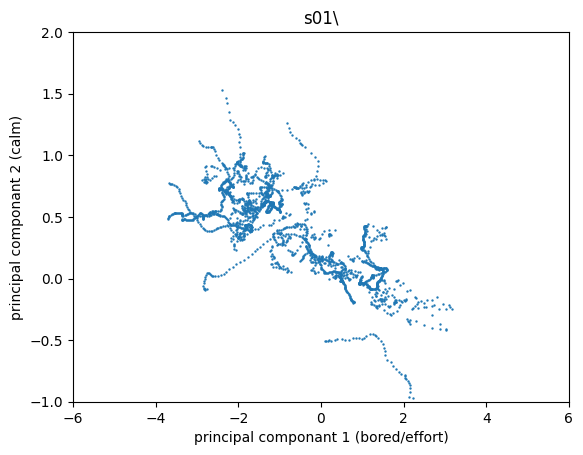

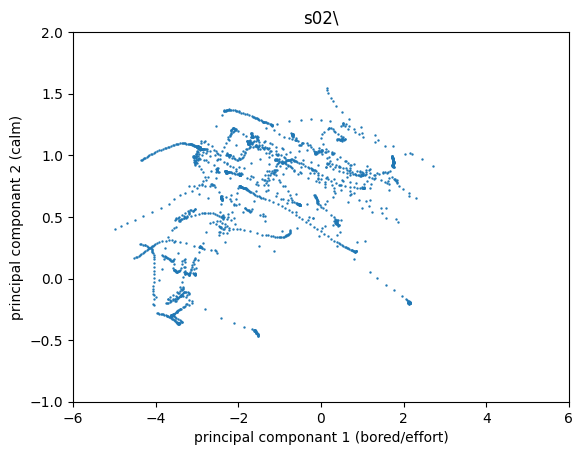

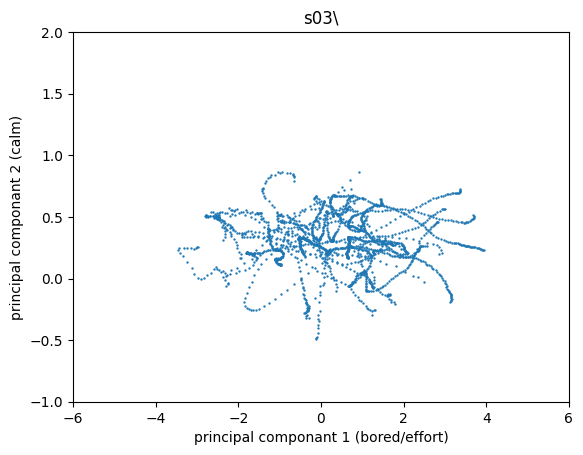

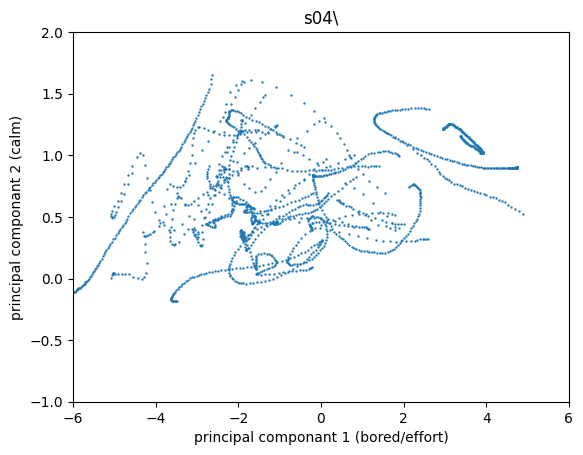

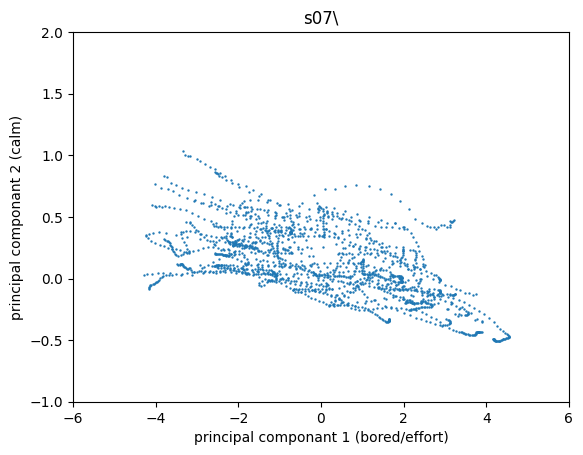

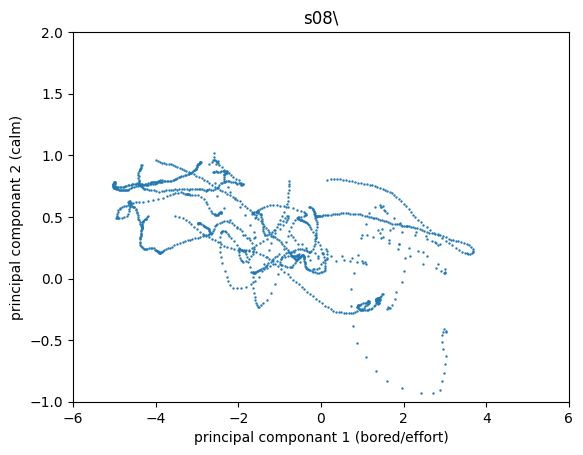

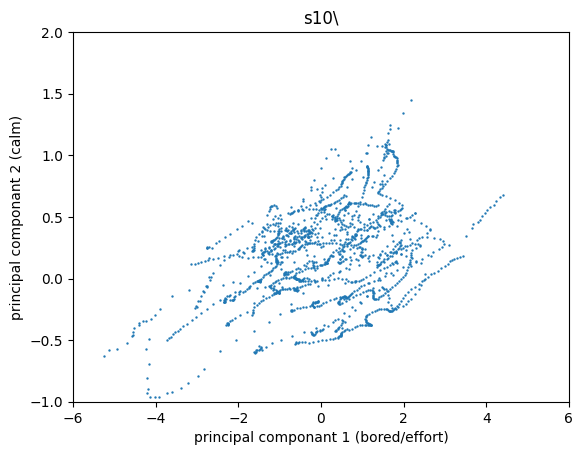

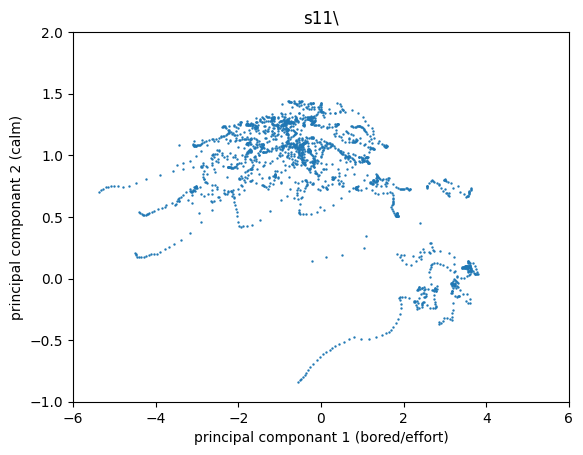

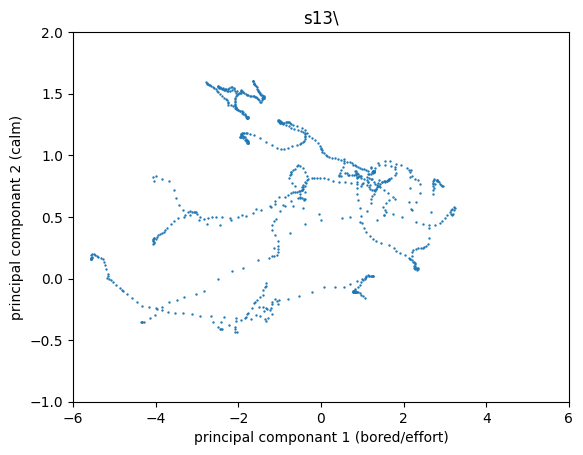

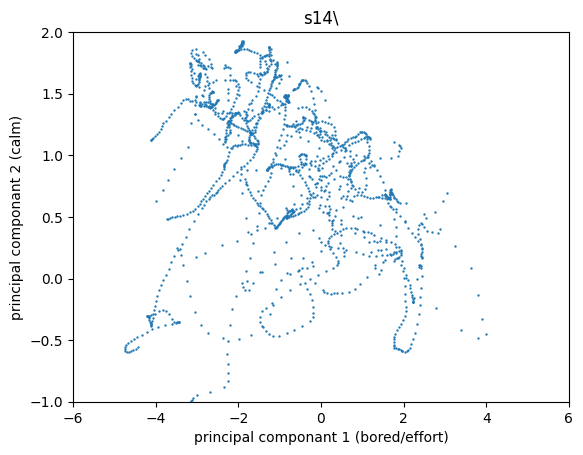

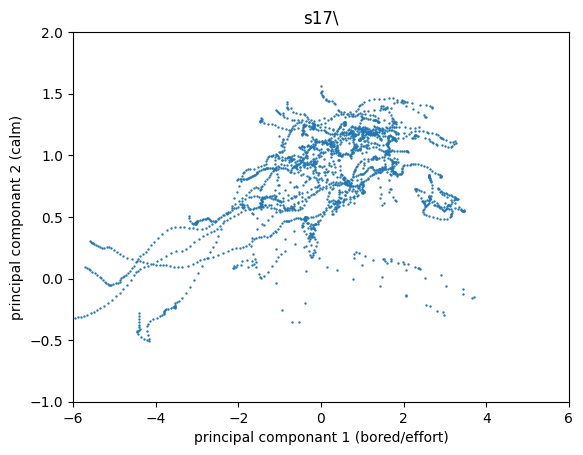

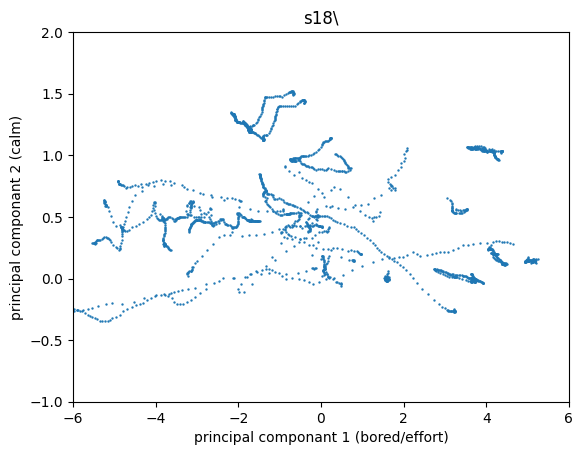

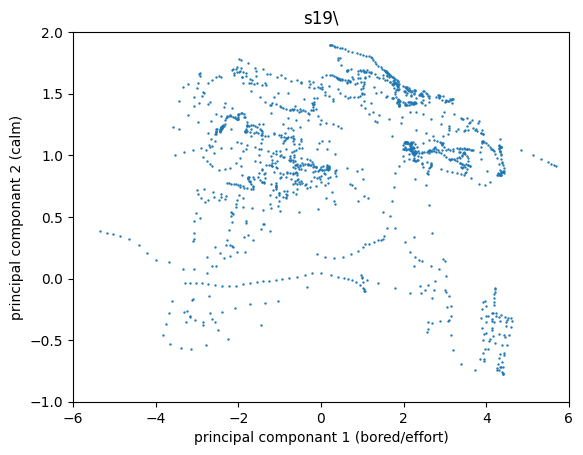

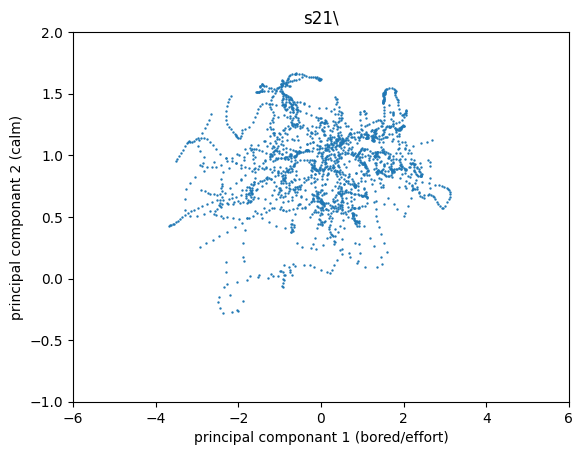

In [ ]:
principal_component_finder_instance = principal_component_finder(df_csv_file,feelings,no_dimensions)
principal_components, explained_variance_ratio, df_TET_feelings_prin = principal_component_finder_instance.PCA_TOT()
df_TET_feelings_prin_dict = principal_component_finder_instance.PCA_split(split_csv_array)

In [ ]:
traj_kmeans_clustering_trunc_instance =  traj_kmeans_clustering_trunc(df_csv_file, feelings, header, principal_components, n_clust)
data = traj_kmeans_clustering_trunc_instance.data_maker()
sum_dist_min = 1000000
id_n_fin = np.zeros(data.shape[2])
clust_fin = np.full((data.shape[0],data.shape[1],n_clust),np.nan)
data_all_clust_fin = np.full((data.shape[0],data.shape[1]+1,data.shape[2]),np.nan)
for n in range(n_rep):
    
    id_n, clust, dist, aux, data_all_clust, sum_dist = traj_kmeans_clustering_trunc_instance.traj_kmeans_mean(1,50)
    print(f'sum dist is {sum_dist}')
    s = traj_kmeans_clustering_trunc_instance.silhouette_et(data,id_n,n_clust)
    sil = np.sum(s)
    print(f'silhouettte score is {sil}')
    if sum_dist<sum_dist_min:
        id_n_fin = id_n
        sum_dist_min = sum_dist
        clust_fin = clust
        data_all_clust_fin = data_all_clust

traj_kmeans_clustering_trunc_instance.traj_plots(colours,id_n_fin)
traj_kmeans_clustering_trunc_instance.centroid_plotter(clust_fin,colours)
data_all_clust_finish = traj_kmeans_clustering_trunc_instance.traj_identifier(data_all_clust_fin)
traj_kmeans_clustering_trunc_instance.indiv_plots(data_all_clust_finish,headers,colours)

NameError: name 'traj_kmeans_clustering_trunc' is not defined

sum dist is [25.75498851]
silhouettte score is 97.32835698214524
sum dist is [36.55092505]
silhouettte score is 52.1988443431757
sum dist is [26.08409377]
silhouettte score is 28.91203277553313
sum dist is [25.30655486]
silhouettte score is 171.78532738481334
sum dist is [22.11974541]
silhouettte score is 67.63371565559734
sum dist is [24.39730912]
silhouettte score is 58.56647633858942
sum dist is [31.74166219]
silhouettte score is 175.50528888769105
sum dist is [25.97517859]
silhouettte score is 14.902030939048327
sum dist is [24.69983641]
silhouettte score is 76.74615748909326
sum dist is [21.97618829]
silhouettte score is 134.24263180158653


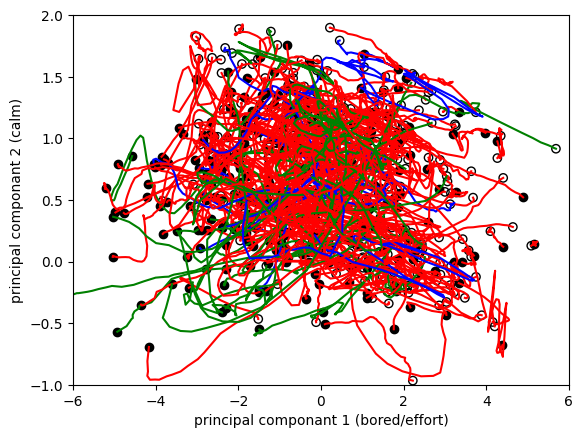

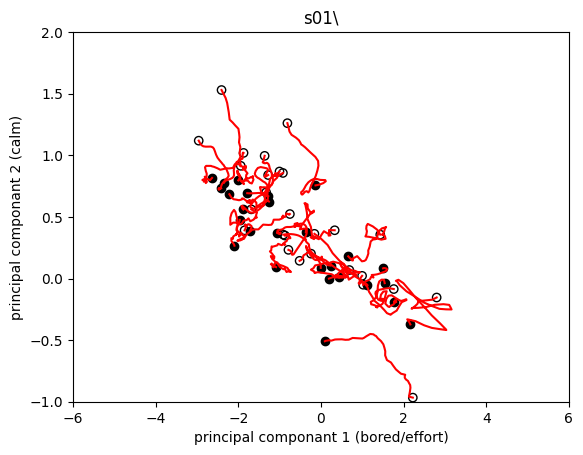

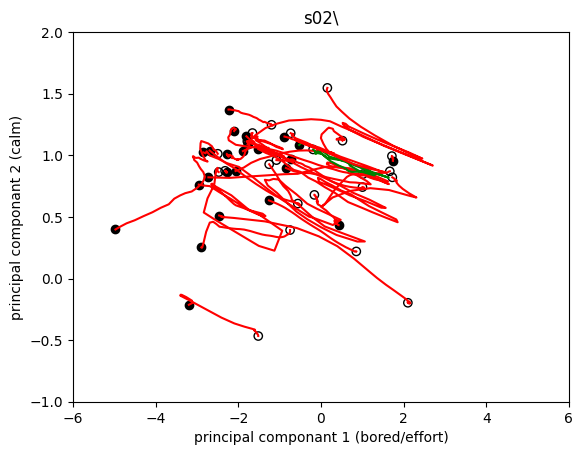

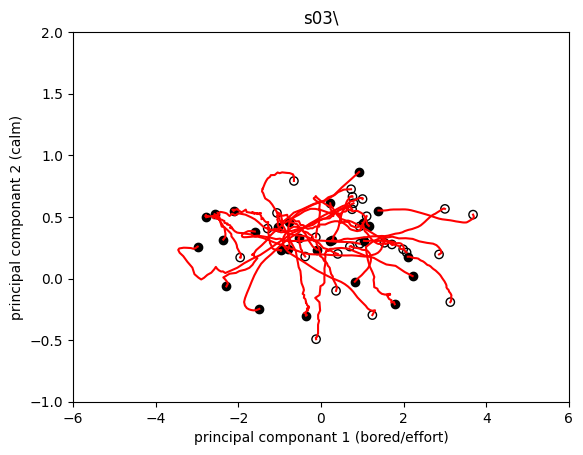

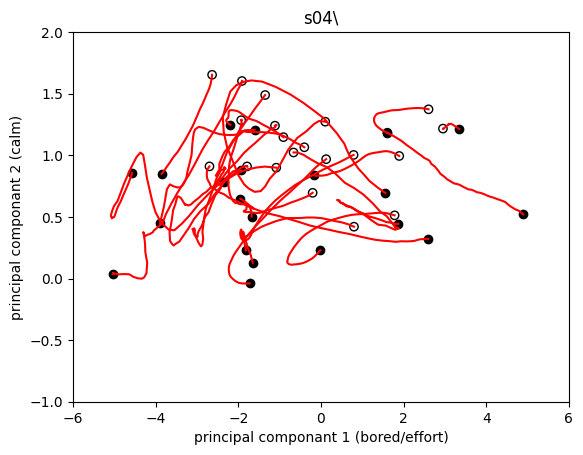

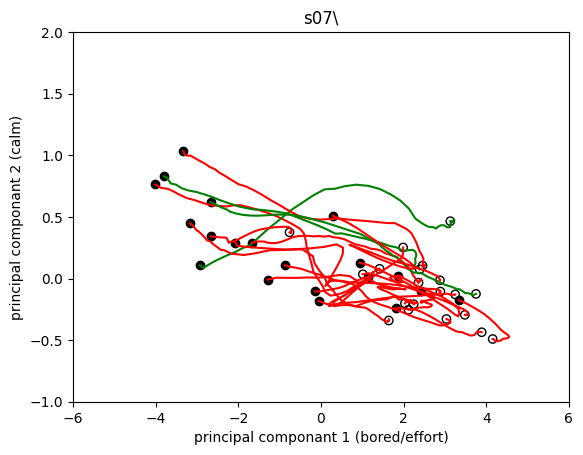

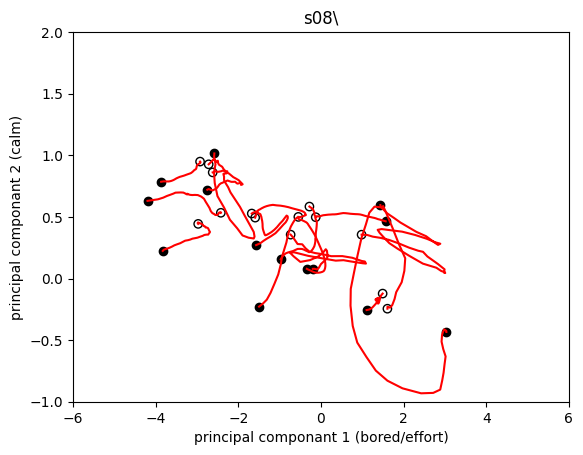

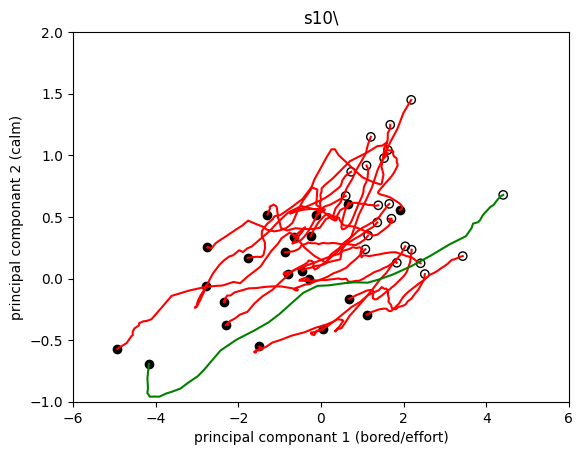

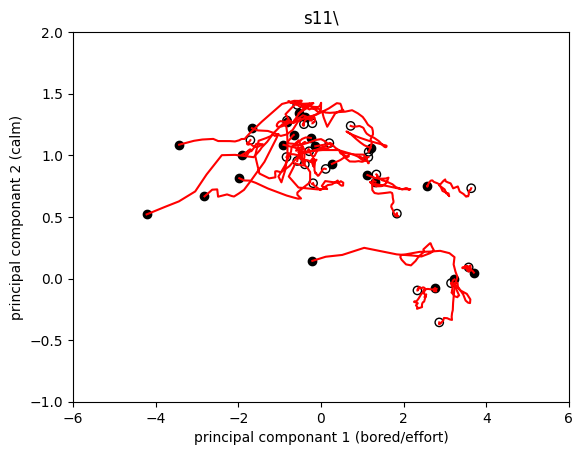

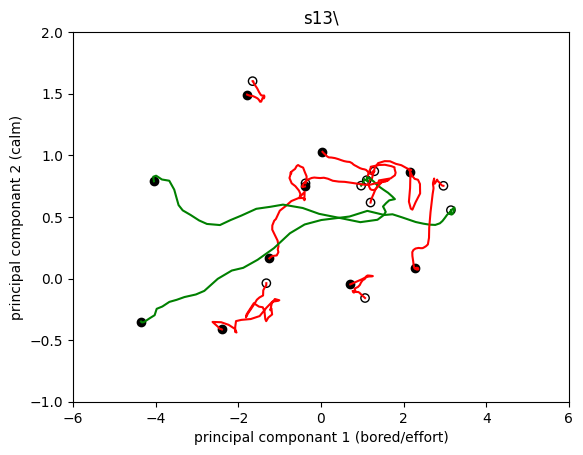

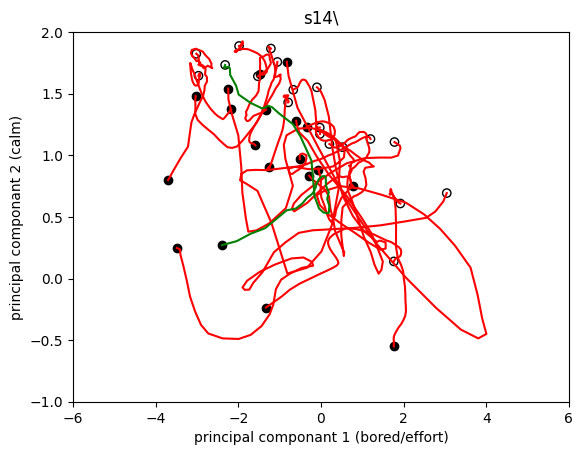

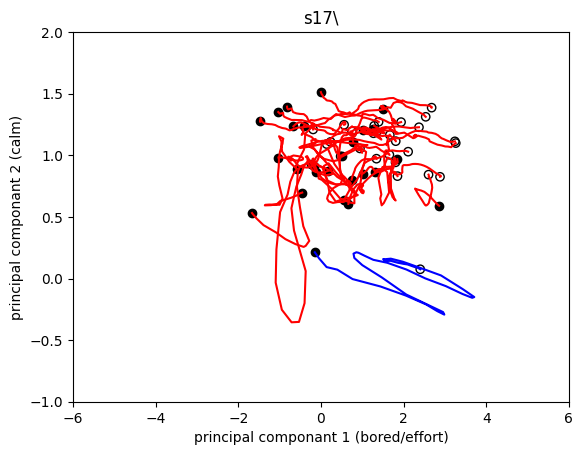

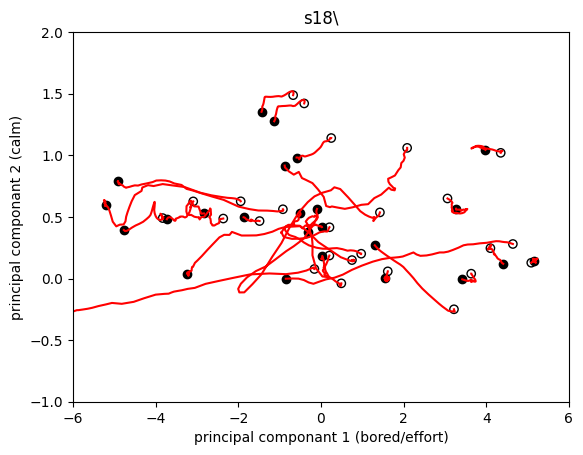

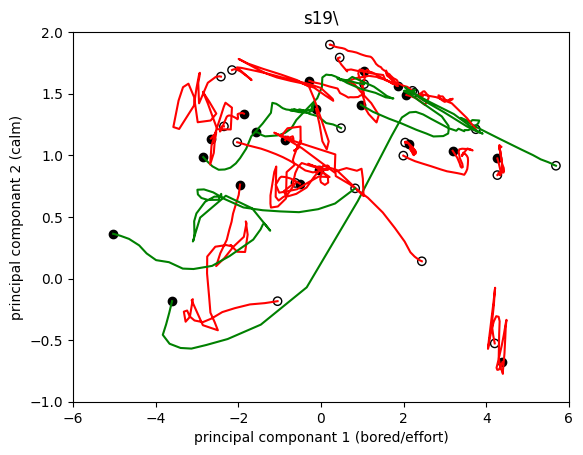

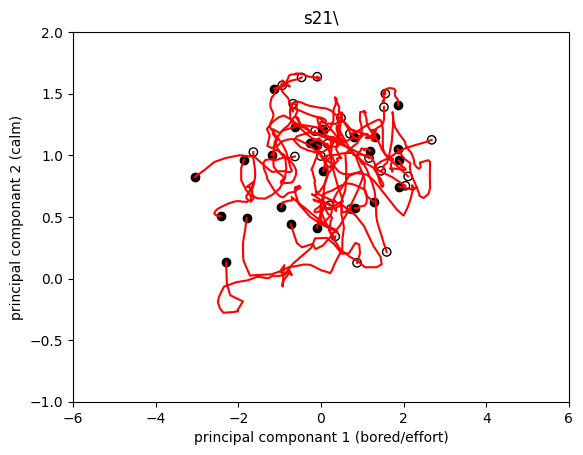

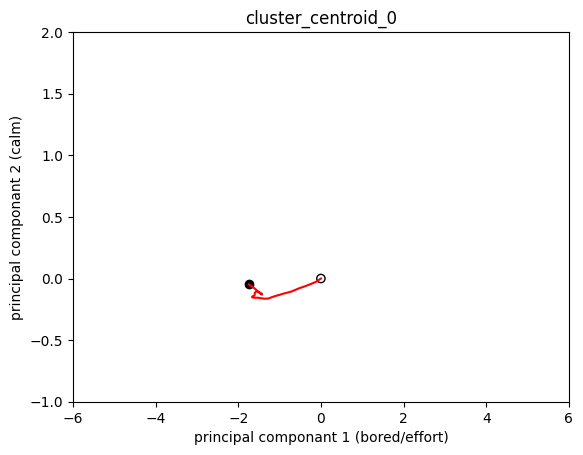

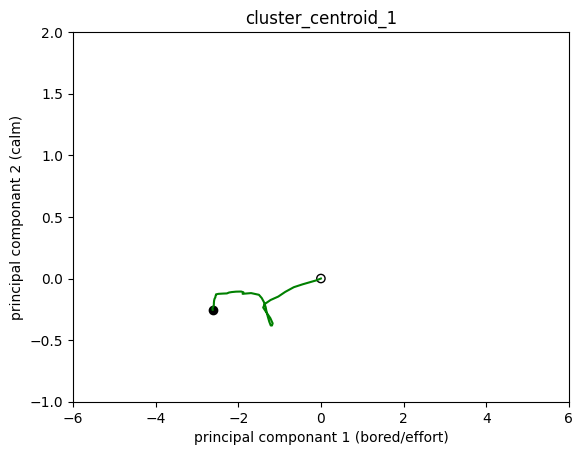

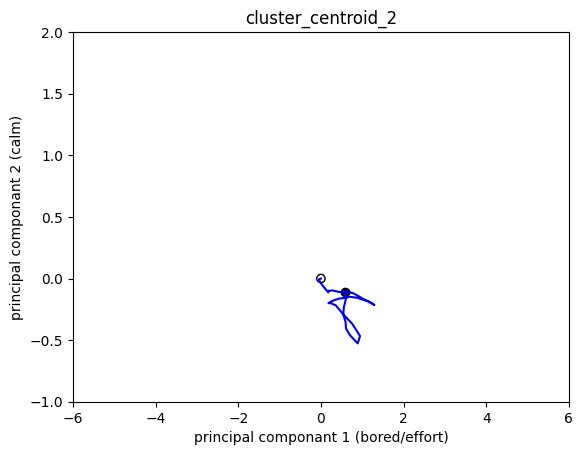

In [ ]:

sum_dist_min_diff = 1000000
id_n_fin_diff = np.zeros(data.shape[2])
clust_fin_diff = np.full((data.shape[0],data.shape[1],n_clust),np.nan)
data_all_clust_fin_diff = np.full((data.shape[0],data.shape[1]+1,data.shape[2]),np.nan)
for n in range(n_rep):
    traj_kmeans_clustering_trunc_instance =  traj_kmeans_clustering_trunc(df_csv_file, feelings, header, principal_components, n_clust)
    id_n_diff, clust_diff, dist_diff, aux_diff, data_all_clust_diff,data_diffs, sum_dist_diff = traj_kmeans_clustering_trunc_instance.traj_kmeans_mean_diffs(1,50)
    print(f'sum dist is {sum_dist_diff}')
    s_diff = traj_kmeans_clustering_trunc_instance.silhouette_et(data_diffs,id_n_diff,n_clust)
    sil_diff = np.sum(s_diff)
    print(f'silhouettte score is {sil_diff}')
    if sum_dist<sum_dist_min_diff:
        id_n_fin_diff = id_n_diff
        sum_dist_min_diff = sum_dist_diff
        clust_fin_diff = clust_diff
        data_all_clust_fin_diff = data_all_clust_diff
traj_kmeans_clustering_trunc_instance.traj_plots(colours,id_n_fin_diff)
data_all_clust_fin_diff = traj_kmeans_clustering_trunc_instance.traj_identifier(data_all_clust_diff)
traj_kmeans_clustering_trunc_instance.indiv_plots(data_all_clust_fin_diff,headers,colours)
traj_kmeans_clustering_trunc_instance.centroid_plotter_diff(clust_fin_diff,colours)

In [ ]:
def silhouette_et(data, id_out, n_clust):
    dist_pairwise = cdist(np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), 
                          np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), metric='euclidean')

    a = np.zeros(data.shape[2])
    b = np.zeros(data.shape[2])
    s = np.zeros(data.shape[2])

    for i in range(data.shape[2]):
        # Calculate the number of points in the same cluster as the current point
        cluster_size = np.sum(id_out == id_out[i])
        
        # If the cluster has only one point, assign a silhouette score of 0
        if cluster_size <= 1:
            s[i] = 0
            continue

        # within-cluster distance
        a[i] = np.nansum(dist_pairwise[i, id_out == id_out[i]]) / (cluster_size - 1)

        # between-cluster distance
        not_clust = np.setdiff1d(np.arange(1, n_clust + 1), id_out[i])

        bmin = np.inf
        for j in not_clust:
            # Calculate the number of points in the current cluster
            cluster_size_j = np.sum(id_out == j)
            
            # If the cluster has no points assigned, skip the calculation
            if cluster_size_j == 0:
                continue
                
            b_aux = np.nansum(dist_pairwise[i, id_out == j]) / cluster_size_j
            bmin = min(b_aux, bmin)

        b[i] = bmin

        s[i] = (b[i] - a[i]) / max(a[i], b[i])
    return s